In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from modules.utils.utils import read_json, build_connection_engine
from sqlalchemy import text
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import math


In [2]:
def assign_signal_label(df, date, col, val):
    """Based on a specific date, assign the boolean label for a specific technical signal specified in a column
    :param df
    :param date
    :param col
    :param val

    returns the dataframe with the reassigned row
    """
    df.loc[df.date == date, col] = val

    return df

def orderOfMagnitude(number):
    """"""

    return math.floor(math.log(number, 10))

def calc_ma_slope_std(df, col, time_window):
    """
    This function calculates the moving average and the slope of a set number of rows based on a defined time window

    :param df -> pandas dataframe
    :param col -> the name of the column to be considered for the ma and slope
    : time_window (int) -> the number of days that will be used to set the window for ma and slope

    returns a pandas DataFrame
    """

    df[f'ma_{col}_{time_window}'] = df[col].rolling(window=time_window).mean()
    df[f'std_{col}_{time_window}'] = df[col].rolling(window=time_window).std()
    df[f'slope_{col}_{time_window}'] = df[col].rolling(time_window, min_periods = time_window).apply(calc_slope)

    return df

def calc_slope(x):
    """
    Simple slope calulation
    """
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope
    
def doji_star(df, col, slope, time_window):
    """
    This function label a row in a pandas dataframe based on a predefined set of constraints. 
    In particular, we obtain a morning doji star if the point is already labelled as a doji and if there is a downward trend reversal. Vice versa, an evening doji star is obtained if there is an upward trend reversal. The trend reversal is calculated based on the mean value of the slope in a predefined time window previous to the current point. The time window used can be different from the slope used to evaluate the trend

    :param df -> pandas DataFrame
    :param col -> the column name of the values to be used
    :param slope -> the type of slope from 5, 10, 20, 50
    :param time_window -> the time window to be used to calculate the mean of the slope through the rolling function. 

    Returns a pandas DataFrame
    """
    df[f'morning_doji_star_{time_window}'] = np.where(
        # here we want to check if there is a doji and there is a trend reversal. to check if there is a trend reversal
        # we impose to check wether the slope of a set time window is changing sign
        (df.doji == 1) & (df[f'slope_{col}_{slope}'] < 0) & ( df[f'slope_{col}_{slope}'].rolling(time_window).mean() > 0), 1, 0
    )

    df[f'evening_doji_star_{time_window}'] = np.where(
        # here we want to check if there is a doji and there is a trend reversal. to check if there is a trend reversal
        # we impose to check wether the slope of a set time window is changing sign
        (df.doji == 1) & (df[f'slope_{col}_{slope}'] > 0) & ( df[f'slope_{col}_{slope}'].rolling(time_window).mean() < 0), 1, 0
    )

    return df
    
def plot_basic_candlestick(df, date_start = None, date_end = None):
    """
    This function plots a basic plotly chart based on a dataframe and a time frame

    :param df -> pandas Dataframe
    :param date_start & date_end -> the time boundaries to plot

    returns plotly plot
    """
    
    if date_start is not None:
        df = df[(df['date'] >= date_start) & (df['date'] <= date_end)]

    fig = go.Figure(data=[go.Candlestick(x=df['date'],
                    open=df['open_price'],
                    high=df['high_price'],
                    low=df['low_price'],
                    close=df['close_price'])])
    fig.update_layout(
        autosize=False,
        width=900,
        height=1200,
    
        paper_bgcolor="LightSteelBlue",
    )
    fig.show()

def plot_candlestick_with_signals(df, signal_col, trend_col, start_date = None, end_date = None, plot_signal = False, plot_trend = False, bollinger_band = False):
    """
    This function plots a plotly candlestick added with external signals and or trends

    :param df
    :param signal_col
    :param: trend_col
    :param start_date and end_date
    :param plot_signal (bool)
    :param plot_trend (cool)
    :param bollinger_band(bool)

    returns plotly plot
    """

    if start_date:
        df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    lst_signal = list(df[df[signal_col] == 1]['time_open'].astype(str))



    # include candlestick with rangeselector
    fig.add_trace(
        go.Candlestick(x=df['date'],
                    open=df['open_price'],
                    high=df['high_price'],
                    low=df['low_price'],
                    close=df['close_price']
                    ), 
                secondary_y=True
                )
    
    if plot_signal:
    # include a go.Bar trace for volumes
        fig.add_trace(
            go.Bar(
                x=df[df[signal_col]==1]['date'], 
                y=df[df[signal_col] == 1].high_price, 
                name = f"Plotting the signal {signal_col}",
                ),
                secondary_y=False
                )

    if plot_trend:
    # include a go.Bar trace for volumes
        fig.add_trace(
            go.Scatter(
                 x=df['date'],
                y=df[trend_col],
                name = f"Trend {trend_col}"
                ),
                    secondary_y=False
                    )
    if bollinger_band:
        fig.add_trace(
            go.Scatter(
                x=df.date, 
                y=df.ma_close_price_20,
                mode='lines',
                name='20days MA',
                line = dict(
                    color='#1E90FF', 
                    width=2, 
                )
            )
        )

        fig.add_trace(
                go.Scatter(
                    x=df.date, 
                    y=(df.ma_close_price_20 + df.std_close_price_20),
                    mode='lines',
                    name='upper band',
                    line = dict(
                        color='#1E90FF', 
                        width=0.5, 
                    )
                )
            )

        fig.add_trace(
                go.Scatter(
                    x=df.date, 
                    y=(df.ma_close_price_20 - df.std_close_price_20),
                    mode='lines',
                    name='lower band',
                    fill='tonexty',
                    line = dict(
                        color='#1E90FF', 
                        width=0.5, 
                    )
                )
            )


    fig.layout.yaxis2.showgrid=False
    fig.update_layout(
        autosize=False,
        width=900,
        height=1200,
    
        paper_bgcolor="LightSteelBlue",
    )
    fig.show()

In [18]:
plot_candlestick_with_signals(df, 'doji', 'ma_close_price_20', start_date = None, end_date = None, plot_signal = False, plot_trend = False, bollinger_band = False)

## ETL and post processing

In [15]:
p = Path(".")

config = read_json(p / "modules"/"config.json")
conn_s = build_connection_engine(config, 's')

table_schema = "cryptovaluer"
hist_coin_t = "historical_coin_data"
harmonized = config.get("DATABASE").get("TABLES").get("harmonized_data_t")


In [17]:
df = pd.read_sql_query(f"select * from {table_schema}.{harmonized} where coin_id = '1'",con=conn_s)

In [389]:

df['date'] = pd.to_datetime(df['time_open']) # time open or time close is the same, as we have daily data
# generate some additional features
df['open_close_pct'] = np.abs((df.open_price - df.close_price)/df.open_price)
df['mean_to_high_pct'] = np.abs((df.high_price - (df.open_price + df.close_price)/2) / df.high_price)
df['mean_to_low_pct'] = np.abs((df.low_price - (df.open_price + df.close_price)/2) / df.low_price)
df['open_close_mean'] = np.abs((df.open_price + df.close_price)/2)
df['high_to_mean_distance_pct'] = (df.high_price - df.open_close_mean)/df.high_price
df['mean_to_low_distance_pct'] = (df.open_close_mean - df.low_price)/df.open_close_mean
df['high_to_mean_distance_pct_magnitude'] = df['high_to_mean_distance_pct'].apply(lambda x: np.floor(np.log10(x)))
df['mean_to_low_distance_pct_magnitude'] = df['mean_to_low_distance_pct'].apply(lambda x: np.floor(np.log10(x)))

# signal heuristic for technical analysis
df['doji'] = np.where(
    # rule to identify doji if open close pct is at or lower 2% and mean to high minus mean to low are ~ at 1% then is a doji
    (df.open_close_pct <= 0.005) &  ((np.abs(df.mean_to_high_pct - df.mean_to_low_pct)	 <= 0.005)), 1, 0
)

df['dragonfly'] = np.where(
    # rule to identify dragonfly is to check that open and close price are the same (only 0.5% difference) and the magnitude of the tail is towards the lower price
    (df.open_close_pct <= 0.005) &  (np.abs(df.mean_to_low_distance_pct.values) - np.abs(df.high_to_mean_distance_pct_magnitude.values) <= 1) & (df.doji == 0) & (df.mean_to_low_pct - df.mean_to_high_pct > 0.02)
    , 1, 0
)

df['gravestone'] = np.where(
    # rule to identify dragonfly is to check that open and close price are the same (only 0.5% difference) and the magnitude of the tail is towards the higher price
    (df.open_close_pct <= 0.005) &  (np.abs(df.mean_to_low_distance_pct.values) - np.abs(df.high_to_mean_distance_pct_magnitude.values) <= 1)  & (df.mean_to_high_pct - df.mean_to_low_pct > 0.02) & ((df.doji == 0) & (df.dragonfly == 0))
    , 1, 0
)

# generate the MA 
cols = ['open_price', 'close_price', 'high_price', 'low_price']
time_windows = [5, 10, 20, 50]

for col in cols:
    for t in time_windows:
        df = calc_ma_slope_std(df, col, t)
        df = doji_star(df, col, t, t)

df['close_price_to_ma_20_ratio'] = df['close_price']/df['ma_close_price_20'] 
df['open_price_to_ma_20_ratio'] = df['open_price']/df['ma_open_price_20'] 






In [391]:
df.head()

,coin_id,name,rank,time_open,time_close,time_high,time_low,open_price,close_price,high_price,...,close_price_to_ma_20_ratio,open_price_to_ma_20_ratio,morning_doji_star_20,evening_doji_star_20,morning_doji_star_5,evening_doji_star_5,morning_doji_star_10,evening_doji_star_10,morning_doji_star_50,evening_doji_star_50
0,1,Bitcoin,1,2013-04-28,2013-04-29,2013-04-28,2013-04-28,103.845271,103.008678,104.367178,...,NaN,NaN,0,0,0,0,0,0,0,0
1,1,Bitcoin,1,2013-04-29,2013-04-30,2013-04-29,2013-04-29,103.124952,110.869060,113.130326,...,NaN,NaN,0,0,0,0,0,0,0,0
2,1,Bitcoin,1,2013-04-30,2013-05-01,2013-04-30,2013-04-30,109.974034,106.155491,112.211694,...,NaN,NaN,0,0,0,0,0,0,0,0
3,1,Bitcoin,1,2013-05-01,2013-05-02,2013-05-01,2013-05-01,105.591006,88.871162,106.267092,...,NaN,NaN,0,0,0,0,0,0,0,0
4,1,Bitcoin,1,2013-05-02,2013-05-03,2013-05-02,2013-05-02,88.307153,79.831549,95.303133,...,NaN,NaN,0,0,0,0,0,0,0,0


## EDA and signal testing


In [402]:
#
#plot_candlestick_with_signals(df, 'morning_doji_star_20', 'ma_open_price_20', plot_signal =True, plot_trend = True, bollinger_band = True)

In [293]:
#plot_basic_candlestick(df, date_start = '2021-12-13', date_end = '2021-12-15')

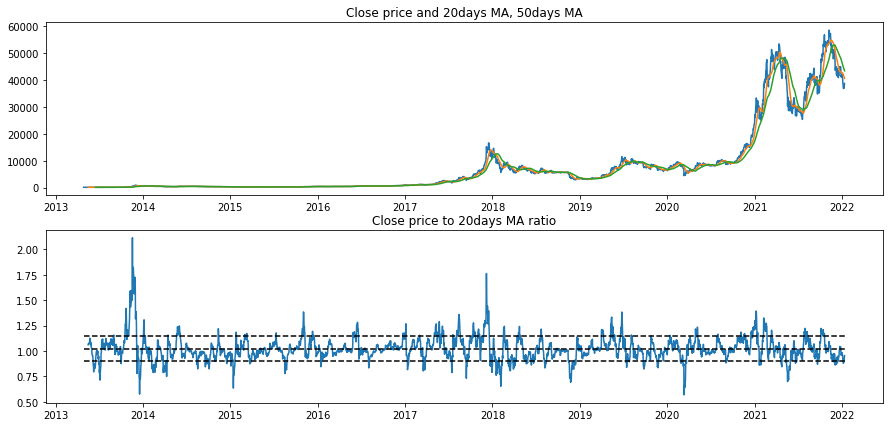

In [331]:
f = plt.figure(figsize=(15,7))
ax = f.add_subplot(211)
ax2 = f.add_subplot(212)

#plot 1:
x = df.date
y = df.close_price
y1 = df.ma_close_price_20
y2 = df.ma_close_price_50

ax.set_title("Close price and 20days MA, 50days MA")
ax.plot(x,y)
ax.plot(x,y1)
ax.plot(x,y2)

#plot 2:
x = df.date
y = df.close_price_to_ma_20_ratio
y1 = df.close_price_to_ma_20_ratio.mean()
y2 = df.close_price_to_ma_20_ratio.quantile(0.1)
y3 = df.close_price_to_ma_20_ratio.quantile(0.9)


ax2.plot(x,y)
ax2.hlines(y1, df.date.min(), df.date.max(), 'black', 'dashed')
ax2.hlines(y2, df.date.min(), df.date.max(), 'black', 'dashed')
ax2.hlines(y3, df.date.min(), df.date.max(), 'black', 'dashed')

ax2.set_title("Close price to 20days MA ratio")
plt.show()

